# Data processing and manipulation techniques


## Manipulation of data in the frequency domain

In the previous data processing class we explored the Fourier transform, how to code it up, and how to apply it. Now let's investigate some examples of data manipulation techniques that are easier, or more natural, to perform in the frequency domain.

I emphasize that *any* operation performed in the frequency domain can always be equivalently performed in the time domain. There are some subtleties to this, and reasons to sometimes use the frequency domain, or the time domain, as we will explore.

Let's begin with the following data example:

 * We will generate a dataset that is 256 seconds long sampled 16 times a second.
 * In this dataset we will add Gaussian noise with frequencies up to 1Hz, but not above it.
 * We will also add a sine wave at 4Hz, but the amplitude will be much smaller than the Gaussian noise.
 * The idea is that in the time-domain the sine-wave is not visible at all, but it can be easily extracted from the data because there is no overlap in the *frequency* components of the noise and the signal.

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

We are going to need to use Fourier transforms again, so copy in your code from last week.

In [ ]:
#def compute_fourier_transform(data_time_domain):
#    # REDACTED FROM SOLUTION NOTEBOOK
#    return data_frequency_domain

#def compute_inverse_fourier_transform(data_frequency_domain):
#    # REDACTED FROM SOLUTION NOTEBOOK
#    return data_time_domain / N


def compute_fourier_transform(data_time_domain):
    math_i = 1j # This is how to write sqrt(-1) = i in python.
    N = len(data_time_domain) # How many points in the data
    k = np.arange(N)
    n = np.arange(N)
    data_frequency_domain = np.zeros(N,dtype=np.complex128)
    for j in k:
        for i in n:
            data_frequency_domain[j] += data_time_domain[i] * \
                (np.cos(2 * np.pi * j  * i / N) - math_i * np.sin(2 * np.pi * j * i / N))
    return data_frequency_domain

def compute_inverse_fourier_transform(data_frequency_domain):
    math_i = 1j # This is how to write sqrt(-1) = i in python.
    N = len(data_frequency_domain) # How many points in the data
    k = np.arange(N)
    n = np.arange(N)
    data_time_domain = np.zeros(N,dtype=np.complex128)
    for i in n:
        for j in k:
            data_time_domain[j] += data_frequency_domain[i] * \
                (np.cos(2 * np.pi * j  * i / N) + math_i * np.sin(2 * np.pi * j * i / N))
    return data_time_domain / N



And then we generate the data as described.

In [ ]:
# Choose data length and sampling rate
omega = 1. * (2*np.pi)
data_length = 256
sample_rate = 16.
times = np.arange(data_length) / sample_rate

data_time_domain = np.zeros(data_length)
# Add low frequency noise: No components above 1Hz
for i in range(1,17):
    omega = i / 16. * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain += 100*np.sin(times * omega + phase)

# Add in a single 4Hz sine wave
omega = 4. * (2*np.pi)
data_time_domain += np.sin(times * omega)

**EXERCISE** Plot this data in the time domain. Then, using your Fourier transform knowledge from the last class, transform to the frequency domain and plot the data in the frequency domain as well. Convert back to the time domain and verify that you get the original data.

To try to see the sine wave in the frequency domain plot the magnitude of the frequency domain data (remember it is complex) against frequency, and use a log y-axis (plt.semilogy).

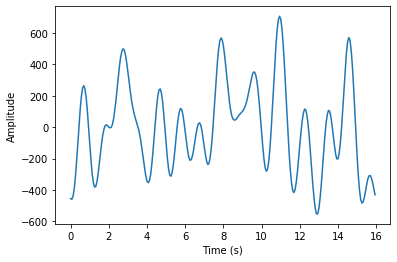

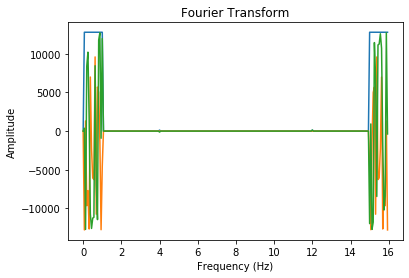

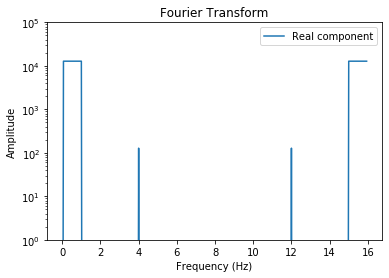

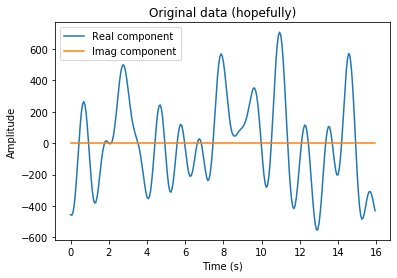

In [ ]:
plt.plot(times, data_time_domain)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
frequencies = np.arange(256) * (sample_rate/data_length)
data_frequency_domain = compute_fourier_transform(data_time_domain)
plt.plot(frequencies, abs(data_frequency_domain))
plt.plot(frequencies, data_frequency_domain.real)
plt.plot(frequencies, data_frequency_domain.imag)
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.figure()
plt.semilogy(frequencies, abs(data_frequency_domain))
plt.ylim([1,100000])
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

plt.figure()
data_time_domain_inverted = compute_inverse_fourier_transform(data_frequency_domain)
plt.plot(times, data_time_domain_inverted.real)
plt.plot(times, data_time_domain_inverted.imag)
plt.title('Original data (hopefully)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])


Hopefully you can now see a spike in your frequency-domain plot corresponding to the signal. So how would we go about removing the lower-frequency noise from the data to be able to extract this signal? A high-pass filter would do the trick! That would let us remove the low-frequency noise, while not affecting the higher-frequency signal. Let's explore how to do that!

First let's explore a simple approach to the problem. Fourier transform the data, set to 0 all content below 2Hz and then transform back to the time domain:

In [ ]:
# You need to supply a compute_fourier transform function!
data_frequency_domain = compute_fourier_transform(data_time_domain)



**EXERCISE** Zero out all content below 2Hz. Now plot this data in the Fourier domain, and transformed back to the time domain. Can you see the sine wave clearly now? (The answer should be "yes")

Text(0, 0.5, 'Amplitude')

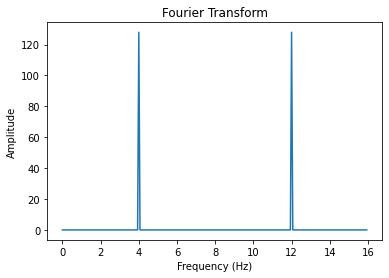

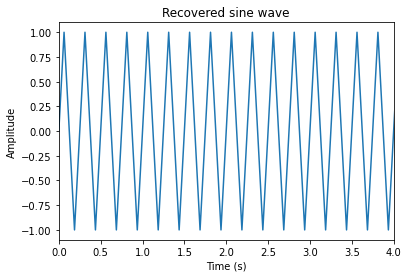

In [ ]:
# Set values below 2Hz to 0 (as this is symmetric we need to remove content at both small *and* large values)
data_frequency_domain[:2*16] = 0
data_frequency_domain[-(2*16):] = 0

plt.figure()
plt.plot(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
#plt.legend(['Real component','Imag component'])

plt.figure()
data_time_domain_inverted = compute_inverse_fourier_transform(data_frequency_domain)
plt.plot(times, data_time_domain_inverted.real)
#plt.plot(times, data_time_domain_inverted.imag)
plt.title('Recovered sine wave')
plt.xlim([0,4])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.legend(['Real component','Imag component'])


At this point, applying a high-pass filter may appear to be very easy. However, in most cases this is not the case. To illustrate this let's try an extension of our first example. We'll generate the same dataset, but instead of generating 16 seconds of data, I'll generate 1024 seconds of data and then cut the data to only keep 16 seconds of that data in the middle.

In [ ]:
times_1024 = np.arange(data_length*64) / sample_rate
data_time_domain_1024 = np.zeros(data_length*64)
# Add low frequency noise: No components above 1Hz
for i in range(1,1025):
    omega = i / 1024. * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain_1024 += 100*np.sin(times_1024 * omega + phase)

# Add in a single 4Hz sine wave
omega = 4. * (2*np.pi)
data_time_domain_1024 += np.sin(times_1024 * omega)

data_time_domain_1024_CUT = data_time_domain_1024[504*16:520*16]

**EXERCISE** Again, plot this CUT data in the Fourier domain, and transform back to the time domain.

Then, as before, transform the CUT data to the Fourier domain, perform a basic high-pass filter, as we did previously, and plot the data again.

Can you see the sine wave on any of this data? (The answer now should be "no")

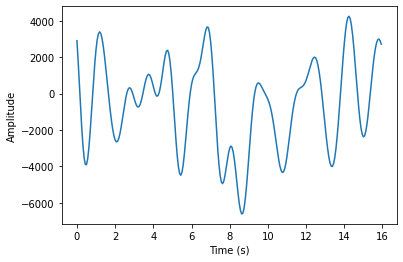

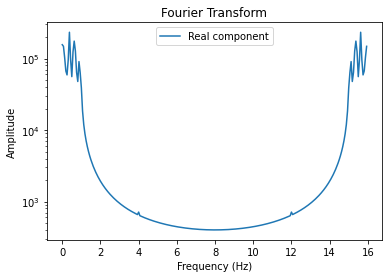

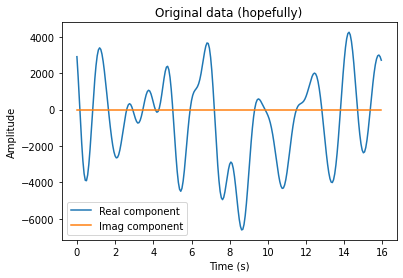

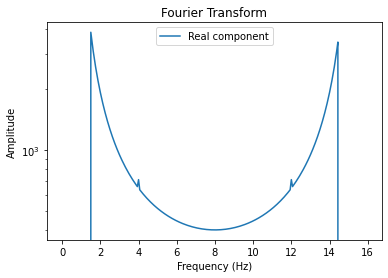

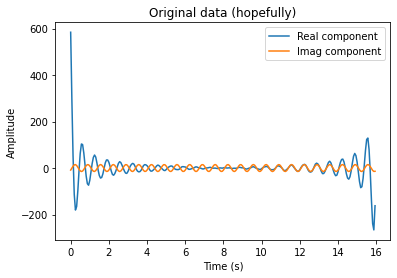

In [ ]:
# CASE 1: Notice here that now Fourier transform is imaginary (and so symmetric part is negative)
plt.plot(times, data_time_domain_1024_CUT)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
data_frequency_domain = compute_fourier_transform(data_time_domain_1024_CUT)
plt.semilogy(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

plt.figure()
data_time_domain_inverted = compute_inverse_fourier_transform(data_frequency_domain)
plt.plot(times, data_time_domain_inverted.real)
plt.plot(times, data_time_domain_inverted.imag)
plt.title('Original data (hopefully)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

# Let's do a high-pass filter. We'll remove all content below 1.5Hz (and the corresponding high-frequency values)
# Let's do this simply in the frequency-domain by zero-ing out all the content
data_frequency_domain[:24] = 0
data_frequency_domain[-24:] = 0
plt.figure()
plt.semilogy(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

plt.figure()
data_time_domain_inverted = compute_inverse_fourier_transform(data_frequency_domain)
plt.plot(times, data_time_domain_inverted.real)
plt.plot(times, data_time_domain_inverted.imag)
plt.title('Original data (hopefully)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

We did the same process as in the previous step, where we *did* manage to extract the signal. So what's the difference here? Why can we not recover the signal in this case?

To answer this we need to think about the theory of Fourier transforms: As we said previously, any discrete time series can be represented as a frequency series by a Fourier transform. However, **this assumes that the data is cyclical**, this means that the data should repeat itself. So in the time domain, we consider that when we reach the end of the dataset we start again at the beginning.

This was not a problem in our first example, because we generated the noise such that the end was smoothly connected to the start. We can see this by repeating the dataset and examining the "join":

Text(0, 0.5, 'Amplitude')

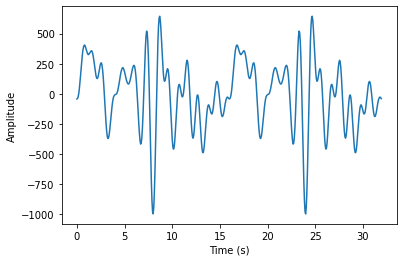

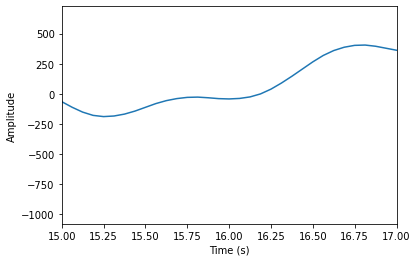

In [ ]:
# Here I am talking the 16 seconds of data, and then *repeating* it so we have 32 seconds of data, where the first
# 16 seconds is identical to the last 16 seconds.
times_32 = np.arange(data_length*2) / sample_rate
plt.plot(times_32, np.append(data_time_domain, data_time_domain))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(times_32,np.append(data_time_domain, data_time_domain))
plt.xlabel('Time (s)')
plt.xlim([15,17])
plt.ylabel('Amplitude')


In this case we can see that the data is repeating, but the "join" is smooth. In contrast, for our CUT dataset:

Text(0, 0.5, 'Amplitude')

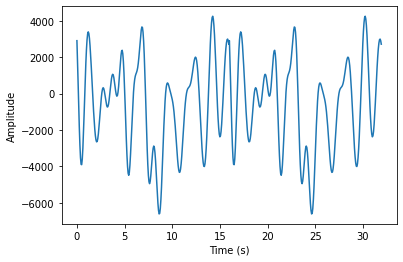

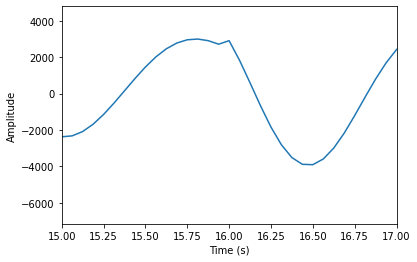

In [ ]:
times_32 = np.arange(data_length*2) / sample_rate
plt.plot(times_32, np.append(data_time_domain_1024_CUT, data_time_domain_1024_CUT))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(times_32,np.append(data_time_domain_1024_CUT, data_time_domain_1024_CUT))
plt.xlabel('Time (s)')
plt.xlim([15,17])
plt.ylabel('Amplitude')


We can see above that the transition here is *not* smooth. Joining these two datasets introduces a delta-function in the data. As we saw earlier a discontinuity, or delta-function, produces broad frequency content in the Fourier transform. The high-pass filter removes a lot of this content, but cannot remove the content above 1Hz.

Unfortunately, most real examples will look like the case above, and not the simple case.

So how do we deal with this? In short, we have to remove the delta-function!

Let's first deal with the case that I am *only* concerned about my 16s data set for now. If I want to get rid of the delta-function. I can "window" the data. This means that data at the edges is set to 0, by multiplying be some sort of smooth curve between 0 and 1 (called a window function). Let's show a quick example of this and then explain a bit more:

Text(0, 0.5, 'Amplitude')

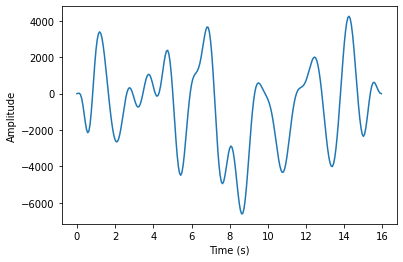

In [ ]:
# IMPORTANT TO USE COPY HERE SO WE DON'T EDIT BOTH ARRAYS!!
data_time_domain_1024_CUT_windowed = np.copy(data_time_domain_1024_CUT[:])
data_time_domain_1024_CUT_windowed[:17] = data_time_domain_1024_CUT_windowed[:17] * (0.5 - 0.5*np.cos(times[:17] * np.pi))
data_time_domain_1024_CUT_windowed[-17:] = data_time_domain_1024_CUT_windowed[-17:] * (0.5 + 0.5*np.cos(times[:17] * np.pi))

plt.plot(times, data_time_domain_1024_CUT_windowed)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


What we have done here is taper the data to 0 at both ends. This will remove some actual content from the data, but will ensure that the data meets (mostly) smoothly at the ends (the second derivative is not continuous at this point, so it is not truly smooth with the window I chose!) We can, however, see that this data joins up much better in the middle.

**EXERCISE** Show that the data is now smooth if we join the start of the data to the end (by making the same plot as we made above over 32 seconds). Then Fourier transform this data again, and see if we can see the signal now. Also use our basic high-pass filter on this windowed data and see if we can extract the signal in the time domain. HINT: Try removing data up to 3Hz to improve ability to extract the signal!

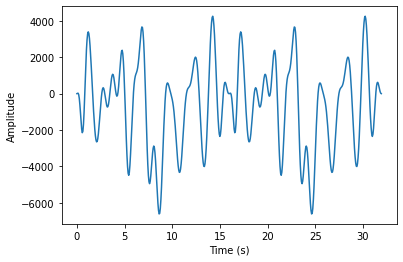

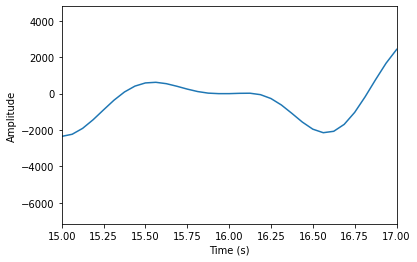

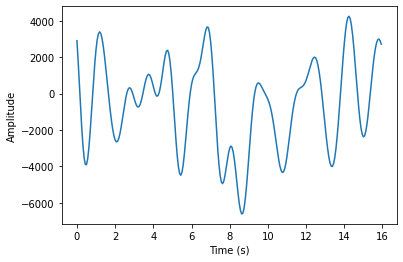

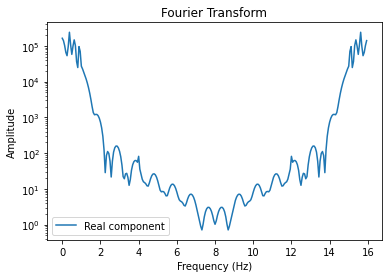

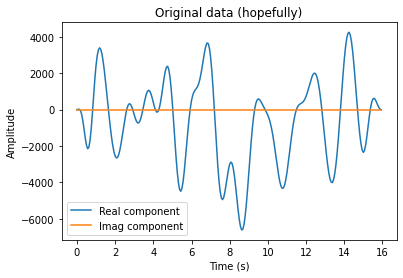

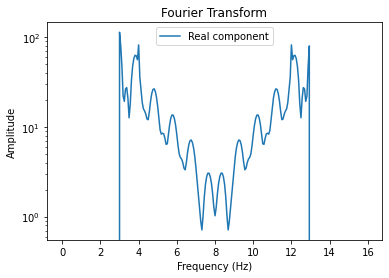

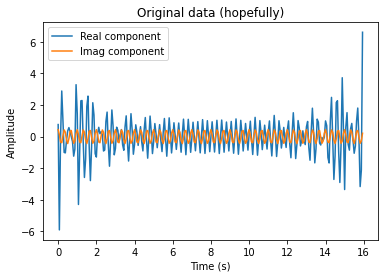

In [ ]:
times_32 = np.arange(data_length*2) / sample_rate
plt.figure()
plt.plot(times_32, np.append(data_time_domain_1024_CUT_windowed, data_time_domain_1024_CUT_windowed))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(times_32,np.append(data_time_domain_1024_CUT_windowed, data_time_domain_1024_CUT_windowed))
plt.xlabel('Time (s)')
plt.xlim([15,17])
plt.ylabel('Amplitude')

plt.figure()
plt.plot(times, data_time_domain_1024_CUT)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
data_frequency_domain = compute_fourier_transform(data_time_domain_1024_CUT_windowed)
plt.semilogy(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

plt.figure()
data_time_domain_inverted = compute_inverse_fourier_transform(data_frequency_domain)
plt.plot(times, data_time_domain_inverted.real)
plt.plot(times, data_time_domain_inverted.imag)
plt.title('Original data (hopefully)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

# Let's do a high-pass filter. We'll remove all content below 1.5Hz (and the corresponding high-frequency values)
# Let's do this simply in the frequency-domain by zero-ing out all the content
data_frequency_domain[:48] = 0
data_frequency_domain[-48:] = 0
plt.figure()
plt.semilogy(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

plt.figure()
data_time_domain_inverted = compute_inverse_fourier_transform(data_frequency_domain)
plt.plot(times, data_time_domain_inverted.real)
plt.plot(times, data_time_domain_inverted.imag)
plt.title('Original data (hopefully)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])


In this case, we should be able to see a spike in the Fourier domain data at 4Hz, but the windowing itself introduces some noise at all frequencies, and we do not perfectly recover the sine wave .... This is the general real-world example! This could be improved by (for example) using a better windowing function. For example we could have windowed more data, smoothing out the noise due to the window, but removing more of the data. There's also a variety of possible ways to smoothly bring data to 0:

https://en.wikipedia.org/wiki/Window_function

Some of which may perform well in this instance.

**OPTIONAL EXERCISE** Investigate if you can better recover the signal in this 16 seconds CUT dataset by using different windowing filters, or different filter lengths.

In [ ]:
# This one is really left up to you, as there's lots of things that could be done
# ... Some of which are demonstrated further down anyway!

However, we should remember that our CUT dataset was in total 1024 seconds long. If we are able to use the *full* dataset, we should be better able to extract the signal! One approach to doing this would be to just analyse the full dataset in one go. We can Fourier transform the full set, we could window (for example) 8 seconds of data on either end, and hopefully extract the signal well.

**EXERCISE** Can you recover the signal from directly analysing the full 1024 seconds of data, as described above? (In a short test case, I was able to clearly see the content in the frequency domain).

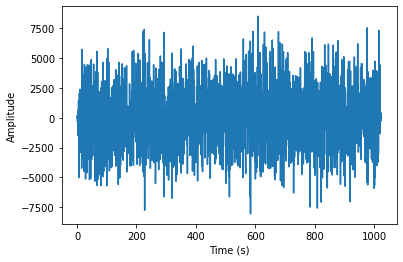

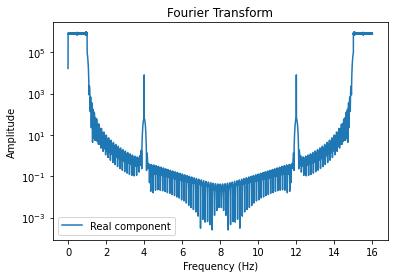

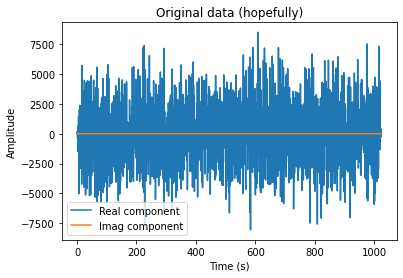

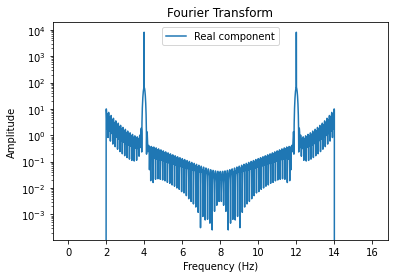

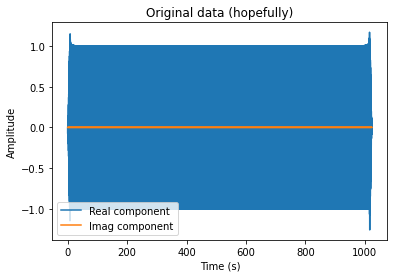

In [ ]:
data_time_domain_1024_windowed = np.copy(data_time_domain_1024[:])
data_time_domain_1024_windowed[:16*8+1] = data_time_domain_1024_windowed[:16*8+1] * (0.5 - 0.5*np.cos(times[:16*8+1] * np.pi/8.))
data_time_domain_1024_windowed[-(16*8+1):] = data_time_domain_1024_windowed[-(16*8+1):] * (0.5 + 0.5*np.cos(times[:16*8+1] * np.pi/8.))
frequencies_1024 = np.arange(1024*16) * (sample_rate/(1024*16))


plt.plot(times_1024, data_time_domain_1024_windowed)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
data_frequency_domain = compute_fourier_transform(data_time_domain_1024_windowed)
plt.semilogy(frequencies_1024, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

plt.figure()
data_time_domain_inverted = compute_inverse_fourier_transform(data_frequency_domain)
plt.plot(times_1024, data_time_domain_inverted.real)
plt.plot(times_1024, data_time_domain_inverted.imag)
plt.title('Original data (hopefully)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

# Let's do a high-pass filter. We'll remove all content below 1.5Hz (and the corresponding high-frequency values)
# Let's do this simply in the frequency-domain by zero-ing out all the content
data_frequency_domain[:1024*2] = 0
data_frequency_domain[-1024*2:] = 0
plt.figure()
plt.semilogy(frequencies_1024, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

plt.figure()
data_time_domain_inverted = compute_inverse_fourier_transform(data_frequency_domain)
plt.plot(times_1024, data_time_domain_inverted.real)
plt.plot(times_1024, data_time_domain_inverted.imag)
plt.title('Original data (hopefully)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])



However, sometimes computing the Fourier transform on a long stretch of data can become computationally difficult in this case we may want to work on shorter data stretches. So let's think about approaching this differently: Remember how we said anything that we do in the frequency domain, can be done in the time domain? In the frequency-domain our high-pass filter is simply a multiplication operation: We multiply the frequency-domain data by our filter. In the time domain this is a *convolution* operation:

Here's the wikipedia page: https://en.wikipedia.org/wiki/Convolution, especially we are using the "Convolution Theorem". There are other resources on the web describing this as well, but let's just demonstrate it.

Text(0.5, 0, 'Times (s)')

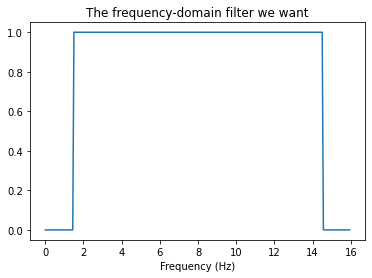

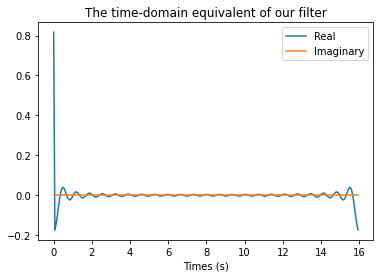

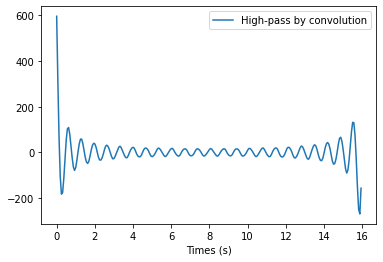

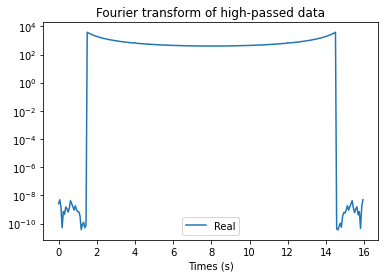

In [ ]:
# We want to apply the following "filter" to our data in the frequency domain
high_pass_filter = np.zeros(len(frequencies), dtype=np.complex128)
high_pass_filter[24:-23] = 1
plt.title("The frequency-domain filter we want")
plt.plot(frequencies, high_pass_filter.real)
plt.xlabel("Frequency (Hz)")

# Let plot this in the time domain
high_pass_filter_time_domain = compute_inverse_fourier_transform(high_pass_filter)
plt.figure()
plt.title("The time-domain equivalent of our filter")
plt.plot(times, high_pass_filter_time_domain.real)
plt.plot(times, high_pass_filter_time_domain.imag)
plt.legend(['Real', 'Imaginary'])
plt.xlabel("Times (s)")


# To apply the high-pass-filter in the time-domain we use convolution.
# Here we continue to use the Fourier convention of assuming the data is cyclical!
high_passed_data = np.zeros(len(times))
# This is a convolution. There are numpy functions for this, but let's demonstrate it first
for i in range(len(times)):
    for j in range(0,256):
        k = i - j
        # This bit cycles the data
        if k < 0:
            k += 256
        high_passed_data[i] += data_time_domain_1024_CUT[j] * high_pass_filter_time_domain.real[k]


plt.figure()
plt.plot(times, high_passed_data)
plt.xlabel("Times (s)")
plt.legend(['High-pass by convolution', 'High-pass in frequency domain'])

# Let plot the "high-passed" data in the frequency domain
high_passed_f_data = compute_fourier_transform(high_passed_data)
plt.figure()
plt.title("Fourier transform of high-passed data")
plt.semilogy(frequencies, abs(high_passed_f_data))
plt.legend(['Real', 'Imaginary'])
#plt.ylim([1000,10000])
plt.xlabel("Times (s)")


You could also choose to apply this *without* wrapping the data from the start to the end. Instead ignoring any points where the data is not available. This also doesn't work brilliantly.

Text(0.5, 0, 'Times (s)')

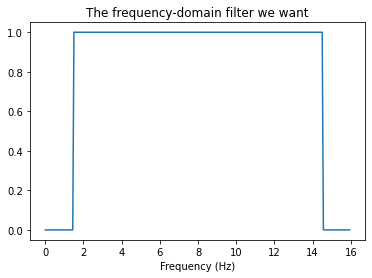

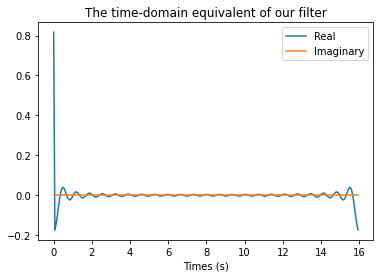

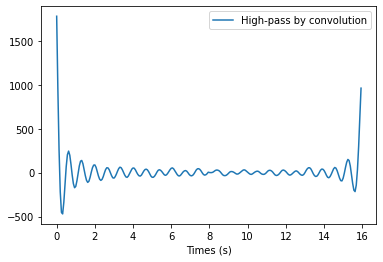

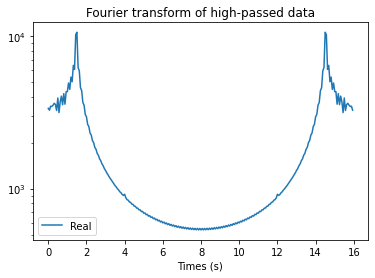

In [ ]:
# We want to apply the following "filter" to our data in the frequency domain
high_pass_filter = np.zeros(len(frequencies), dtype=np.complex128)
high_pass_filter[24:-23] = 1
plt.title("The frequency-domain filter we want")
plt.plot(frequencies, high_pass_filter.real)
plt.xlabel("Frequency (Hz)")

# Let plot this in the time domain
high_pass_filter_time_domain = compute_inverse_fourier_transform(high_pass_filter)
plt.figure()
plt.title("The time-domain equivalent of our filter")
plt.plot(times, high_pass_filter_time_domain.real)
plt.plot(times, high_pass_filter_time_domain.imag)
plt.legend(['Real', 'Imaginary'])
plt.xlabel("Times (s)")

high_pass_filter_time_domain = np.append(high_pass_filter_time_domain[128:], high_pass_filter_time_domain[:128])

# To apply the high-pass-filter in the time-domain we use convolution.
# Here we continue to use the Fourier convention of assuming the data is cyclical!
high_passed_data = np.zeros(len(times))
# This is a convolution. There are numpy functions for this, but let's demonstrate it first
for i in range(len(times)):
    for j in range(0,256):
        k = i - j + 128
        if k < 0 or k > 255:
            continue
        high_passed_data[i] += data_time_domain_1024_CUT[j] * high_pass_filter_time_domain.real[k]


plt.figure()
plt.plot(times, high_passed_data)
plt.xlabel("Times (s)")
plt.legend(['High-pass by convolution', 'High-pass in frequency domain'])

# Let plot the "high-passed" data in the frequency domain
high_passed_f_data = compute_fourier_transform(high_passed_data)
plt.figure()
plt.title("Fourier transform of high-passed data")
plt.semilogy(frequencies, abs(high_passed_f_data))
plt.legend(['Real', 'Imaginary'])
plt.xlabel("Times (s)")


BUT we do have the data available, we have 1024 seconds of it. So we can use the full set of data, and perform a convolution over a longer period of time.

Text(0, 0.5, 'Amplitude')

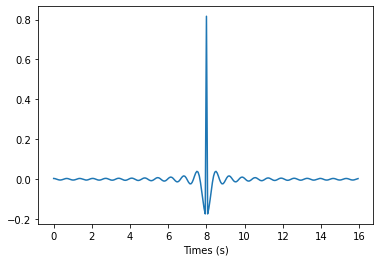

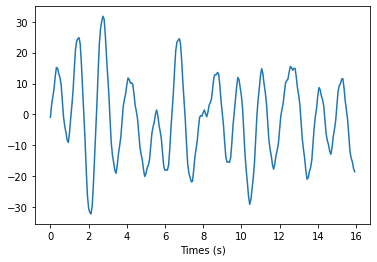

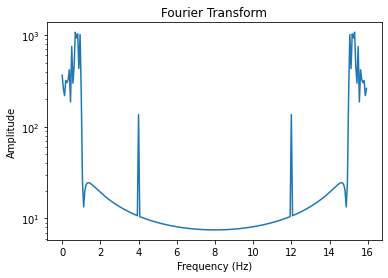

In [ ]:
# We want to apply the following "filter" to our data in the frequency domain
high_pass_filter = np.zeros(len(frequencies), dtype=np.complex128)
high_pass_filter[24:-23] = 1
high_pass_filter_time_domain = compute_inverse_fourier_transform(high_pass_filter)
high_pass_filter_time_domain = high_pass_filter_time_domain.real


# This is cyclical in the time domain so we can shift it forward 128 cycles. We do this to put the
# peak of the filter in the middle, so that when we apply this to a longer stretch of data we minimize the effect
# of the discontinuity
tmp = np.zeros(len(high_pass_filter_time_domain))
tmp[128:] = high_pass_filter_time_domain[:128]
tmp[:128] = high_pass_filter_time_domain[128:]
high_pass_filter_time_domain = tmp
plt.figure()
plt.plot(times, high_pass_filter_time_domain)
plt.xlabel("Times (s)")

# To apply the high-pass-filter in the time-domain we use convolution. Now we do not assume the data is cyclical
high_passed_data = np.zeros(len(times_1024) - len(high_pass_filter_time_domain))
# This is a convolution. There are numpy functions for this, but let's demonstrate it first
for i in range(len(high_passed_data)):
    for j in range(len(high_pass_filter_time_domain)):
        k = i + j
        high_passed_data[i] += high_pass_filter_time_domain[j] * data_time_domain_1024[k]


high_passed_data_CUT = high_passed_data[104*16:120*16]

plt.figure()
plt.plot(times, high_passed_data_CUT)
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(high_passed_data_CUT)
plt.semilogy(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

We're getting there! This did reduce the power of the low-frequency components of the data, but clearly it is still there, and we still can't easily see our 4Hz signal in the time domain. The issue here is still the same: the filter itself was generated assuming cyclical data, which this is not. Before we tried to alleviate this by applying a window to the data itself, but we can also apply the window to our high-pass filter. Let's illustrate that:

Text(0, 0.5, 'Amplitude')

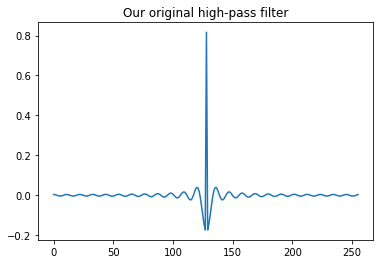

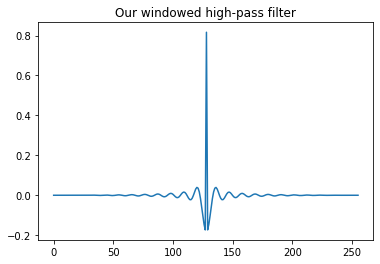

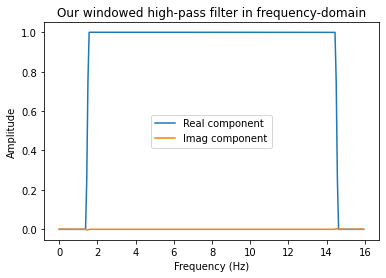

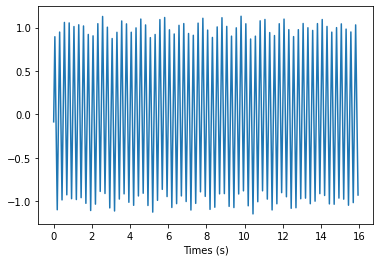

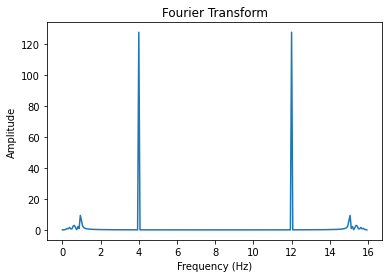

In [ ]:
# We want to apply the following "filter" to our data in the frequency domain
high_pass_filter = np.zeros(len(frequencies), dtype=np.complex128)
high_pass_filter[24:-23] = 1
high_pass_filter_time_domain = compute_inverse_fourier_transform(high_pass_filter)
high_pass_filter_time_domain = high_pass_filter_time_domain.real


# This is cyclical in the time domain so we can shift it forward 128 cycles. We do this to put the
# peak of the filter in the middle, so that when we apply this to a longer stretch of data we minimize the effect
# of the discontinuity
tmp = np.zeros(len(high_pass_filter_time_domain))
tmp[128:] = high_pass_filter_time_domain[:128]
tmp[:128] = high_pass_filter_time_domain[128:]
high_pass_filter_time_domain = tmp
plt.figure()
plt.title("Our original high-pass filter")
plt.plot(high_pass_filter_time_domain)

# Multiply filter by "Hann" window to enforce it go to 0
for i in range(len(high_pass_filter_time_domain)):
    window_func = 0.5 * (1 - np.cos(2*np.pi*i/ (len(high_pass_filter_time_domain)-1) ) )
    high_pass_filter_time_domain[i] = high_pass_filter_time_domain[i] * window_func

plt.figure()
plt.title("Our windowed high-pass filter")
plt.plot(high_pass_filter_time_domain)

# What does this look like now in the frequency domain?
plt.figure()
data_frequency_domain = compute_fourier_transform(np.append(high_pass_filter_time_domain[128:],
                                                            high_pass_filter_time_domain[:128]))
plt.plot(frequencies, data_frequency_domain.real)
plt.plot(frequencies, data_frequency_domain.imag) # This is complex, so need to lines
plt.title('Our windowed high-pass filter in frequency-domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

# To apply the high-pass-filter in the time-domain we use convolution. Now we do not assume the data is cyclical
high_passed_data = np.zeros(len(times_1024) - len(high_pass_filter_time_domain))
# This is a convolution. There are numpy functions for this, but let's demonstrate it first
for i in range(len(high_passed_data)):
    for j in range(len(high_pass_filter_time_domain)):
        k = i + j
        high_passed_data[i] += high_pass_filter_time_domain[j] * data_time_domain_1024[k]


high_passed_data_CUT = high_passed_data[504*16:520*16]

plt.figure()
plt.plot(times, high_passed_data_CUT)
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(high_passed_data_CUT)
plt.plot(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')


And with this we have managed to recover the original signal pretty well from the data! There is still a little bit of noise present, but this, for the most part, has worked well.

SUMMARY: This was a long example. What are the main points I'm trying to get across here?

* High-pass filtering real data has a *lot* of subtleties, and can never be done perfectly. This is not just a plug-and-play and expect everything to work brilliantly type of situation.
* Designing an appropriate filter for different operations has a lot of tunable parameters. How long should the filter be? How aggressively do I window it? What window do I use? How sharp do I need the filter to be?
* Scipy, in particular, provides some really nice functionality to automatically make appropriate filters. For the most part, you would just use scipy for this kind of thing, but getting a sense of the kind of decisions that it must make, and hide from you, is important to knowing why it doesn't work if you make certain choices!

Let's show how to do this with scipy (which will also be quicker than our hand-written filter example)

(0.0, 10.0)

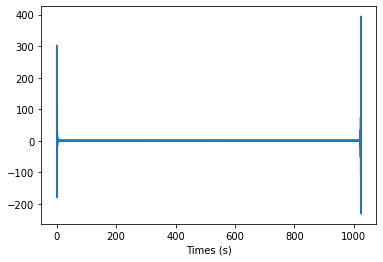

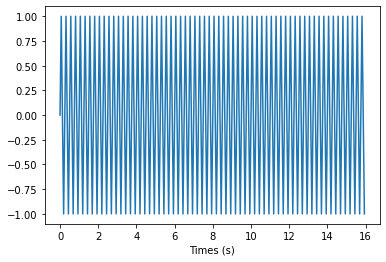

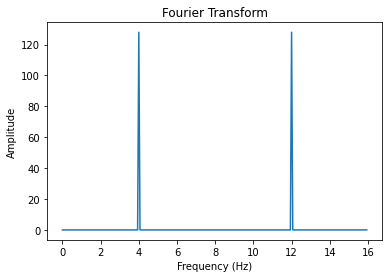

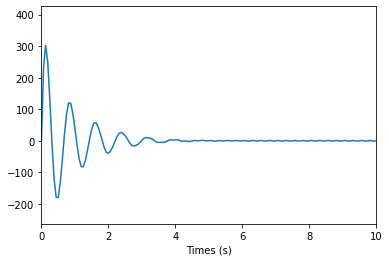

In [ ]:
import scipy.signal
# As with many things in python, good examples always exist on places like stackoverflow. It is not wrong to use
# these, but you should credit where they come from.

# https://dsp.stackexchange.com/questions/41184/high-pass-filter-in-python-scipy
def highpass_filter_scipy(data, sample_rate):
    # As we saw above, our filter cannot be an abrupt cut off. Here we say that no frequency content below 1Hz will
    # be passed, and all frequency content above 1.5Hz will be passed. Between there some content will be passed.
    filter_stop_freq = 1 # Hz
    filter_pass_freq = 1.5  # Hz
    # The filter order is how long (in samples) the filter will be. We used 256 before, so use it again here.
    # However, due to symmetry, we enter (256 / 2) + 1
    filter_order = 129

    # High-pass filter
    nyquist_rate = sample_rate / 2.
    desired = (0, 0, 1, 1)
    bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
    filter_coefs = scipy.signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

    # Apply high-pass filter
    filtered_data = scipy.signal.filtfilt(filter_coefs, [1], data)
    return filtered_data

# Use scipy to high-pass filter the data
data_time_domain_1024_scipy_passed = highpass_filter_scipy(data_time_domain_1024, 16)
plt.figure()
plt.plot(times_1024, data_time_domain_1024_scipy_passed)
plt.xlabel("Times (s)")

# Wait, that looks rubbish? Let's zoom in
data_time_domain_1024_scipy_passed_CUT = data_time_domain_1024_scipy_passed[504*16:520*16]

plt.figure()
plt.plot(times, data_time_domain_1024_scipy_passed_CUT)
plt.xlabel("Times (s)")

# This second one looks great

plt.figure()
data_frequency_domain = compute_fourier_transform(data_time_domain_1024_scipy_passed_CUT)
plt.plot(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

# But the first and last 8s of the data (128 samples) are corrupted
plt.figure()
plt.plot(times_1024, data_time_domain_1024_scipy_passed)
plt.xlabel("Times (s)")
plt.xlim([0,10])



### EXERCISES

* Take data_time_domain_CASE_11 below and create, and perform, a low-pass filter, removing all frequency content above 2Hz. Using scipy will be easier, but your choice. Demonstrate that the 0.5Hz signal buried in that data is visible in both the time and frequency domains.
* Take data_time_domain_CASE_12 below and perform a "band-pass" filter. Specifically, remove all frequency content above 4Hz and below 1Hz. Can you recover the 2Hz signal in that data?
* CHALLENGING: The data_time_domain_CASE_13 below contains "pink" noise (lower frequency content is louder than higher frequency content). Can you convert this into "white" noise where the contribution to the noise at all frequencies is equal?


In [ ]:
data_time_domain_CASE_11 = np.zeros(data_length*64)
# Add low frequency noise: No components above 1Hz
for i in range(2*1024,8*1024):
    omega = i / 1024. * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain_CASE_11 += 100*np.sin(times_1024 * omega + phase)

# Add in a single 4Hz sine wave
omega = 0.5 * (2*np.pi)
data_time_domain_CASE_11 += np.sin(times_1024 * omega)

In [ ]:
data_time_domain_CASE_12 = np.zeros(data_length*64)
# Add low frequency noise: No components above 1Hz
for i in range(1,1*1024):
    omega = i / 1024. * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain_CASE_12 += 100*np.sin(times_1024 * omega + phase)

for i in range(4*1024,8*1024):
    omega = i / 1024. * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain_CASE_12 += 100*np.sin(times_1024 * omega + phase)

# Add in a single 4Hz sine wave
omega = 2 * (2*np.pi)
data_time_domain_CASE_12 += np.sin(times_1024 * omega)

In [ ]:
data_time_domain_CASE_13 = np.zeros(data_length*64)
# Add low frequency noise: No components above 1Hz
for i in range(1,8*1024):
    omega = i / 1024. * (2*np.pi)
    phase=np.random.random() * (2*np.pi)
    data_time_domain_CASE_13 += (1./i)*np.sin(times_1024 * omega + phase)

(0.0, 10.0)

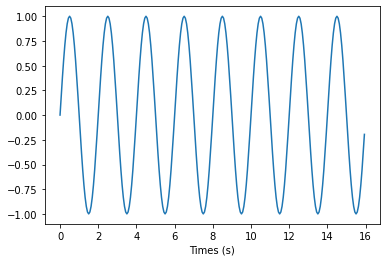

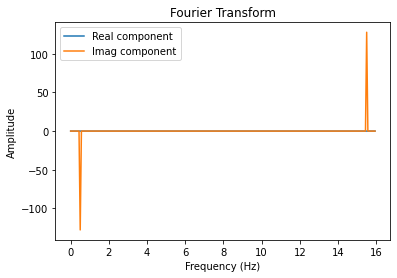

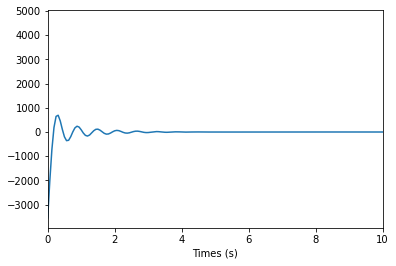

In [ ]:
# EXAMPLE SOLUTION FOR CASE 11

def lowpass_filter_scipy(data, sample_rate):
    # As we saw above, our filter cannot be an abrupt cut off. Here we say that no frequency content below 1Hz will
    # be passed, and all frequency content above 1.5Hz will be passed. Between there some content will be passed.
    filter_stop_freq = 1.5 # Hz
    filter_pass_freq = 2.  # Hz
    # The filter order is how long (in samples) the filter will be. We used 256 before, so use it again here.
    # However, due to symmetry, we enter (256 / 2) + 1
    filter_order = 129

    # High-pass filter
    nyquist_rate = sample_rate / 2.
    desired = (1, 1, 0, 0)
    bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
    filter_coefs = scipy.signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

    # Apply high-pass filter
    filtered_data = scipy.signal.filtfilt(filter_coefs, [1], data)
    return filtered_data

data_time_domain_CASE_11_scipy_passed = lowpass_filter_scipy(data_time_domain_CASE_11, 16)
data_time_domain_CASE_11_scipy_passed_CUT = data_time_domain_CASE_11_scipy_passed[504*16:520*16]

plt.figure()
plt.plot(times, data_time_domain_CASE_11_scipy_passed_CUT)
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(data_time_domain_CASE_11_scipy_passed_CUT)
plt.plot(frequencies, data_frequency_domain.real)
plt.plot(frequencies, data_frequency_domain.imag)
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

# The first and last 8s of the data (128 samples) are corrupted
plt.figure()
plt.plot(times_1024, data_time_domain_CASE_11_scipy_passed)
plt.xlabel("Times (s)")
plt.xlim([0,10])


(0.0, 10.0)

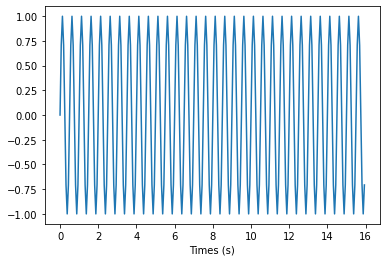

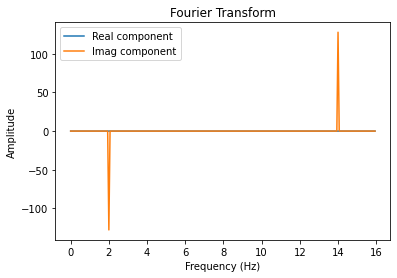

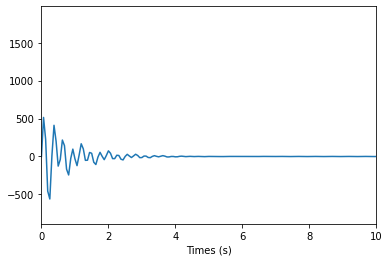

In [ ]:
# EXAMPLE SOLUTION FOR CASE 12

def bandpass_filter_scipy(data, sample_rate):
    # As we saw above, our filter cannot be an abrupt cut off. Here we say that no frequency content below 1Hz will
    # be passed, and all frequency content above 1.5Hz will be passed. Between there some content will be passed.
    filter_start_freq = 1 # Hz
    filter_pass_freq_1 = 1.5  # Hz
    filter_pass_freq_2 = 3.5
    filter_stop_freq = 4.
    # The filter order is how long (in samples) the filter will be. We used 256 before, so use it again here.
    # However, due to symmetry, we enter (256 / 2) + 1
    filter_order = 129

    # High-pass filter
    nyquist_rate = sample_rate / 2.
    desired = (0, 0, 1, 1, 0, 0)
    bands = (0, filter_start_freq, filter_pass_freq_1, filter_pass_freq_2, filter_stop_freq, nyquist_rate)
    filter_coefs = scipy.signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

    # Apply high-pass filter
    filtered_data = scipy.signal.filtfilt(filter_coefs, [1], data)
    return filtered_data

data_time_domain_CASE_12_scipy_passed = bandpass_filter_scipy(data_time_domain_CASE_12, 16)
data_time_domain_CASE_12_scipy_passed_CUT = data_time_domain_CASE_12_scipy_passed[504*16:520*16]

plt.figure()
plt.plot(times, data_time_domain_CASE_12_scipy_passed_CUT)
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(data_time_domain_CASE_12_scipy_passed_CUT)
plt.plot(frequencies, data_frequency_domain.real)
plt.plot(frequencies, data_frequency_domain.imag)
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

# The first and last 8s of the data (128 samples) are corrupted
plt.figure()
plt.plot(times_1024, data_time_domain_CASE_12_scipy_passed)
plt.xlabel("Times (s)")
plt.xlim([0,10])


256 129


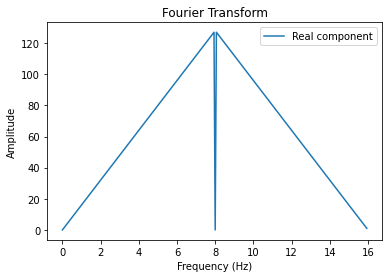

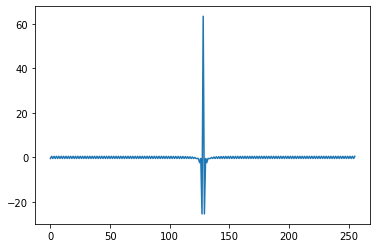

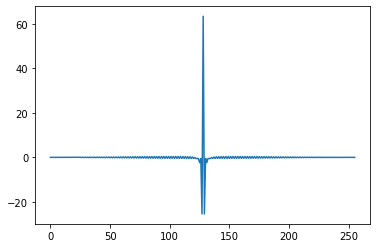

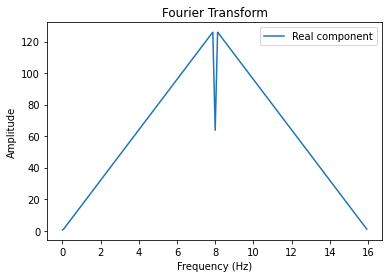

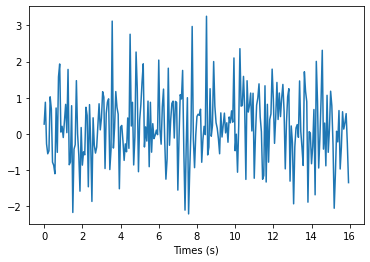

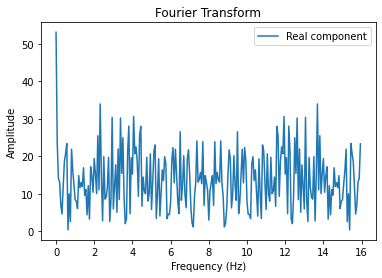

In [ ]:
# EXAMPLE SOLUTION FOR CASE 13
# There's probably a nicer scipy solution to this, but here's one using the filters directly

# We want to apply the following "filter" to our data in the frequency domain
whiten_filter = np.zeros(len(frequencies), dtype=np.complex128)
whiten_filter_nums = np.arange(len(frequencies)//2 + 1, dtype=np.complex128)
print (len(whiten_filter), len(whiten_filter_nums))
whiten_filter[1:len(frequencies)//2] = whiten_filter_nums[1:len(frequencies)//2]
whiten_filter[len(frequencies)//2+1:] = whiten_filter_nums[1:len(frequencies)//2][::-1]

whiten_filter_time_domain = compute_inverse_fourier_transform(whiten_filter)
whiten_filter_time_domain = whiten_filter_time_domain.real

plt.plot(frequencies, abs(whiten_filter))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])



# This is cyclical in the time domain so we can shift it forward 128 cycles. We do this to put the
# peak of the filter in the middle, so that when we apply this to a longer stretch of data we minimize the effect
# of the discontinuity
tmp = np.zeros(len(whiten_filter_time_domain))
tmp[128:] = whiten_filter_time_domain[:128]
tmp[:128] = whiten_filter_time_domain[128:]
whiten_filter_time_domain = tmp
plt.figure()
plt.plot(whiten_filter_time_domain)

# Multiply filter by "Hann" window to enforce it go to 0
for i in range(len(whiten_filter_time_domain)):
    window_func = 0.5 * (1 - np.cos(2*np.pi*i/ (len(whiten_filter_time_domain)-1) ) )
    whiten_filter_time_domain[i] = whiten_filter_time_domain[i] * window_func

plt.figure()
plt.plot(whiten_filter_time_domain)

# What does this look like now in the frequency domain?
plt.figure()
data_frequency_domain = compute_fourier_transform(np.append(whiten_filter_time_domain[128:],
                                                            whiten_filter_time_domain[:128]))
plt.plot(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

# To apply the high-pass-filter in the time-domain we use convolution. Now we do not assume the data is cyclical
high_passed_data = np.zeros(len(times_1024) - len(whiten_filter_time_domain))
# This is a convolution. There are numpy functions for this, but let's demonstrate it first
for i in range(len(high_passed_data)):
    for j in range(len(whiten_filter_time_domain)):
        k = i + j
        high_passed_data[i] += whiten_filter_time_domain[j] * data_time_domain_CASE_13[k]


high_passed_data_CUT = high_passed_data[504*16:520*16]

plt.figure()
plt.plot(times, high_passed_data_CUT)
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(high_passed_data_CUT)
plt.plot(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])

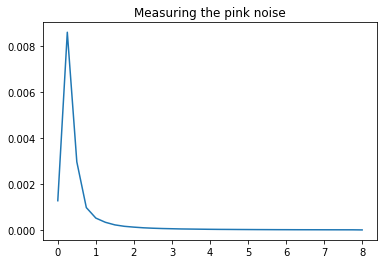

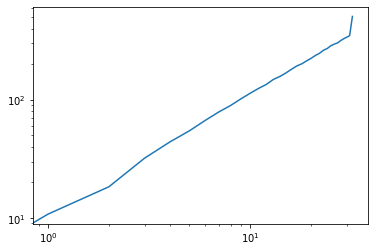

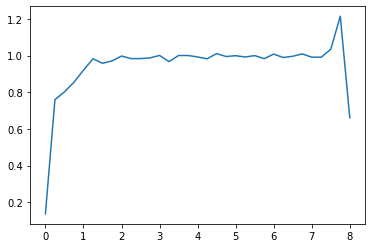

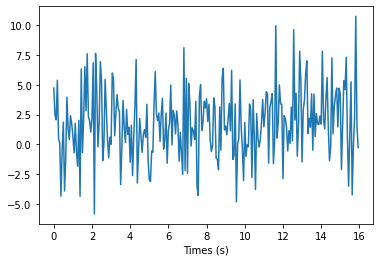

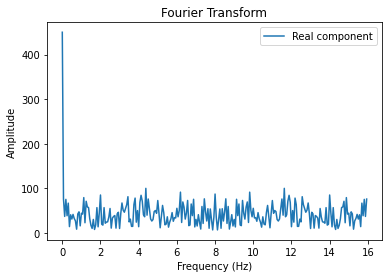

In [ ]:
# An alternative solution to 1.3. This mostly uses the same techniques, but uses numpy/scipy functions directly
# rather than illustrating the code in full
import scipy.signal as sig
from numpy.fft import rfft, irfft

# This measures the frequency spectrum of the noise, rather than relying on knowing that it is pink noise
fs = 16
f, psd = sig.welch(data_time_domain_CASE_13, nperseg=4*fs, fs=fs)

plt.title("Measuring the pink noise")
plt.plot(f, psd)

# Invert this, and plot on loglog
plt.figure()
invasd = psd**-0.5
invasd[0] = 0.
plt.loglog(invasd)

# Now we IFFT this filter and roll it, just as in the solution above
tmp = np.roll(irfft(invasd), 2*fs)
filt = sig.hann(4*fs)*tmp

# And convolve the data with this filter
whitened = sig.convolve(data_time_domain_CASE_13, filt, mode='same')

# Now we measure the spectrum of the data again:
f, psd_w = sig.welch(whitened[2*fs:-2*fs], nperseg=4*fs, fs=fs)
plt.figure()
plt.plot(f, psd_w)

# Or to use the same plotting code as the solution above:
high_passed_data_CUT = whitened[504*16:520*16]

plt.figure()
plt.plot(times, high_passed_data_CUT)
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(high_passed_data_CUT)
plt.plot(frequencies, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(['Real component','Imag component'])
